# Country2Country Citation Relations

In [61]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


Set up the API call. The base URL is filtering the OpenAlex corpus for works by authors with affiliations from one or more countries (*country_codes_1*) and coauthors from one or more countries (*country_codes_2*). The variable *years* is being used to define the timeframe in which the works are published in.

In [54]:
# Define the base URL for the API
base_url = "https://api.openalex.org/works?filter=institutions.country_code:{},institutions.country_code:{},publication_year:"

# List of values for "country_code_1"
country_codes_1 = ["ua"]  # Replace with your specific values

# List of values for "country_code_2"
country_codes_2 = ["de", "pl", "in", "nl", "ru"]  # Replace with your specific values

# List of years to iterate through
years = list(range(2001, 2024))

# List to store the retrieved metadata counts
metadata_counts = []

# Dictionary to store DataFrames for each country combination
country_combination_dfs = {}

In [55]:
# Iterate through the lists of "country_code_1", "country_code_2", and years
for code_1 in country_codes_1:
    for code_2 in country_codes_2:
        for year in years:
            # Create the API URL with the variables
            api_url = base_url.format(code_1, code_2) + str(year)

            # Make the API request
            response = requests.get(api_url)

            # Check if the response is successful (status code 200)
            if response.status_code == 200:
                data = response.json()
                
                # Get the count from the response
                count = data["meta"]["count"]
                
                # Append the country, year, and count to the list
                metadata_counts.append({"Country": f"{code_1} to {code_2}", "Year": year, "Count": count})

# Create a DataFrame from the metadata counts
metadata_df = pd.DataFrame(metadata_counts)

In the next step, the harvested data is put in a dataframe.

In [56]:
# Create DataFrames for each year with the required columns
yearly_dfs = []
for year in years:
    # Filter metadata_df for the specific year
    year_df = metadata_df[metadata_df["Year"] == year]

    # Create a DataFrame with columns "source," "target," and "weight"
    edges_df = pd.DataFrame({
        "source": year_df["Country"].apply(lambda x: x.split(" to ")[0]),
        "target": year_df["Country"].apply(lambda x: x.split(" to ")[1]),
        "weight": year_df["Count"]
    })

    # Append the DataFrame to the list
    yearly_dfs.append(edges_df)

# Print the resulting DataFrames for each year
for idx, year_df in enumerate(yearly_dfs):
    print(f"\nDataFrame for Year {years[idx]}:")
    print(year_df)


DataFrame for Year 2001:
   source target  weight
0      ua     de     315
23     ua     pl     194
46     ua     in       5
69     ua     nl      54
92     ua     ru     279

DataFrame for Year 2002:
   source target  weight
1      ua     de     335
24     ua     pl     217
47     ua     in      12
70     ua     nl      57
93     ua     ru     310

DataFrame for Year 2003:
   source target  weight
2      ua     de     391
25     ua     pl     230
48     ua     in      13
71     ua     nl      46
94     ua     ru     290

DataFrame for Year 2004:
   source target  weight
3      ua     de     407
26     ua     pl     312
49     ua     in      10
72     ua     nl      46
95     ua     ru     333

DataFrame for Year 2005:
   source target  weight
4      ua     de     365
27     ua     pl     240
50     ua     in      15
73     ua     nl      53
96     ua     ru     306

DataFrame for Year 2006:
   source target  weight
5      ua     de     430
28     ua     pl     310
51     ua     in   

Create year-based dataframes

In [57]:
# Iterate through the lists of "country_code_1", "country_code_2", and years
for code_1 in country_codes_1:
    for code_2 in country_codes_2:
        # List to store the retrieved metadata counts
        metadata_counts = []

        # Iterate through the years
        for year in years:
            # Create the API URL with the variables
            api_url = base_url.format(code_1, code_2) + str(year)

            # Make the API request
            response = requests.get(api_url)

            # Check if the response is successful (status code 200)
            if response.status_code == 200:
                data = response.json()

                # Get the count from the response
                count = data["meta"]["count"]

                # Append the year and count to the list
                metadata_counts.append({"Year": year, "Weight": count})

        # Create a DataFrame from the metadata counts
        df_name = f"{code_1}_to_{code_2}"
        country_combination_dfs[df_name] = pd.DataFrame(metadata_counts)

# Print the resulting DataFrames
for df_name, df in country_combination_dfs.items():
    print(f"\nDataFrame for {df_name}:")
    print(df)


DataFrame for ua_to_de:
    Year  Weight
0   2001     315
1   2002     335
2   2003     391
3   2004     407
4   2005     365
5   2006     430
6   2007     428
7   2008     443
8   2009     410
9   2010     427
10  2011     529
11  2012     540
12  2013     564
13  2014     604
14  2015     603
15  2016     695
16  2017     672
17  2018     731
18  2019     808
19  2020     838
20  2021     844
21  2022     875
22  2023     866

DataFrame for ua_to_pl:
    Year  Weight
0   2001     194
1   2002     217
2   2003     230
3   2004     312
4   2005     240
5   2006     310
6   2007     310
7   2008     293
8   2009     312
9   2010     300
10  2011     348
11  2012     396
12  2013     467
13  2014     593
14  2015     762
15  2016     881
16  2017    1027
17  2018    1170
18  2019    1368
19  2020    1395
20  2021    1498
21  2022    1515
22  2023    1509

DataFrame for ua_to_in:
    Year  Weight
0   2001       5
1   2002      12
2   2003      13
3   2004      10
4   2005      15
5   200

A first visualization: A simple bar chart of the counts of works

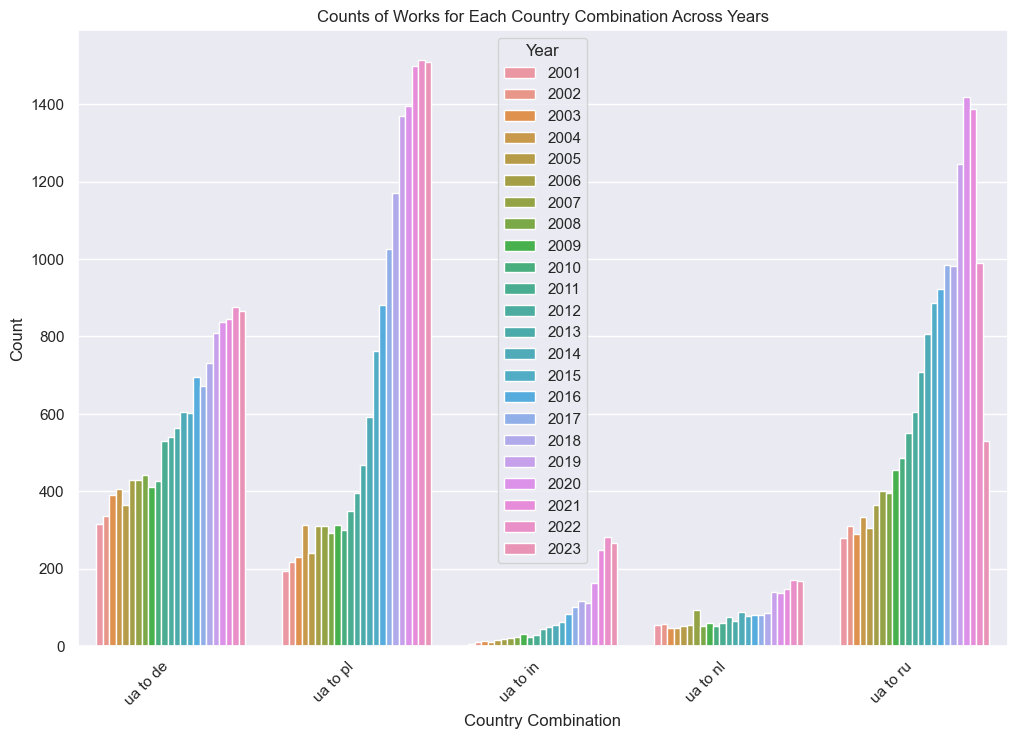

In [58]:
# Change style to dark background
sns.set(style="darkgrid")

# Filter out rows where both countries are the same
filtered_metadata_df = metadata_df[metadata_df['Country'].apply(lambda x: x.split(' to ')[0] != x.split(' to ')[1])]

# Create a bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x="Country", y="Count", hue="Year", data=filtered_metadata_df)
bar_plot.set_title('Counts of Works for Each Country Combination Across Years')
bar_plot.set_xlabel('Country Combination')
bar_plot.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

Next step: Creating a network with a directed graph. Work in progress.

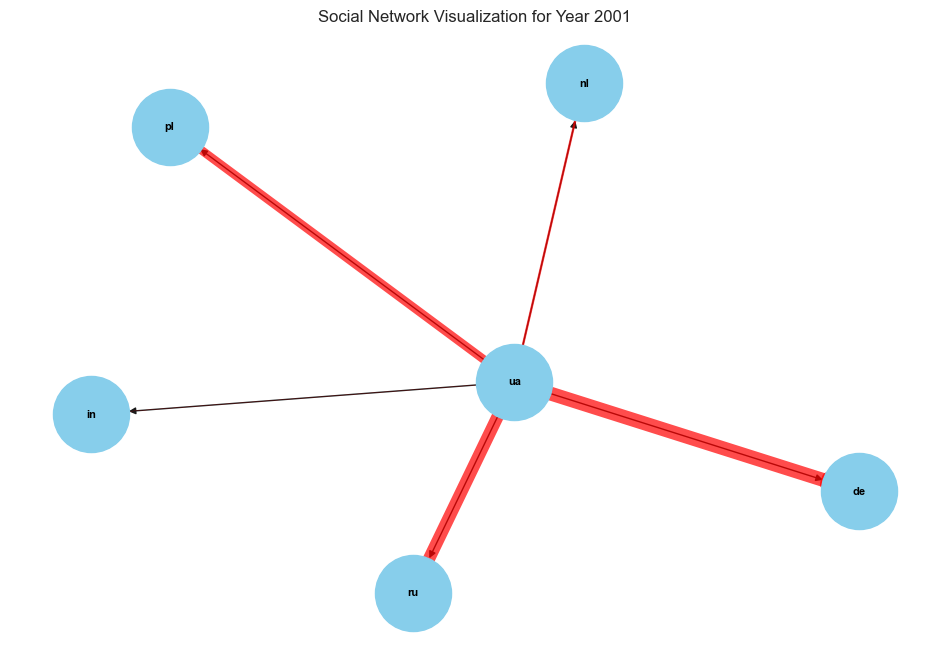

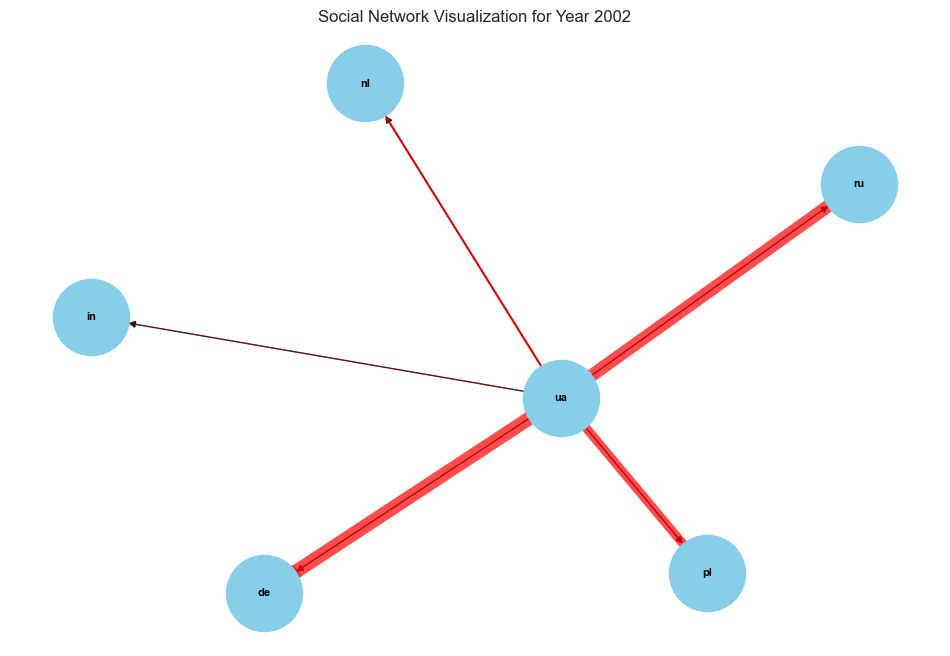

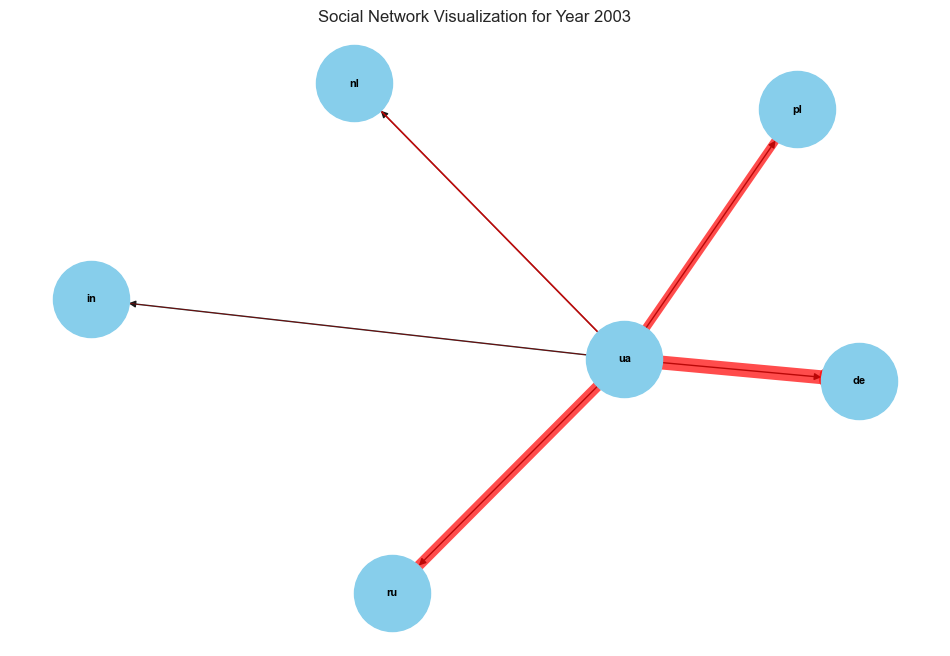

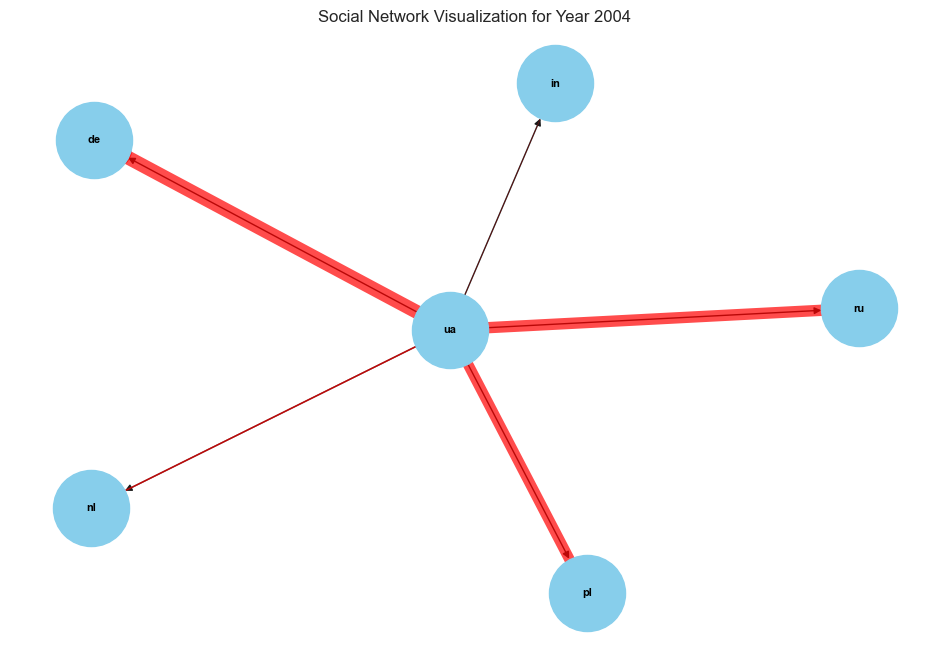

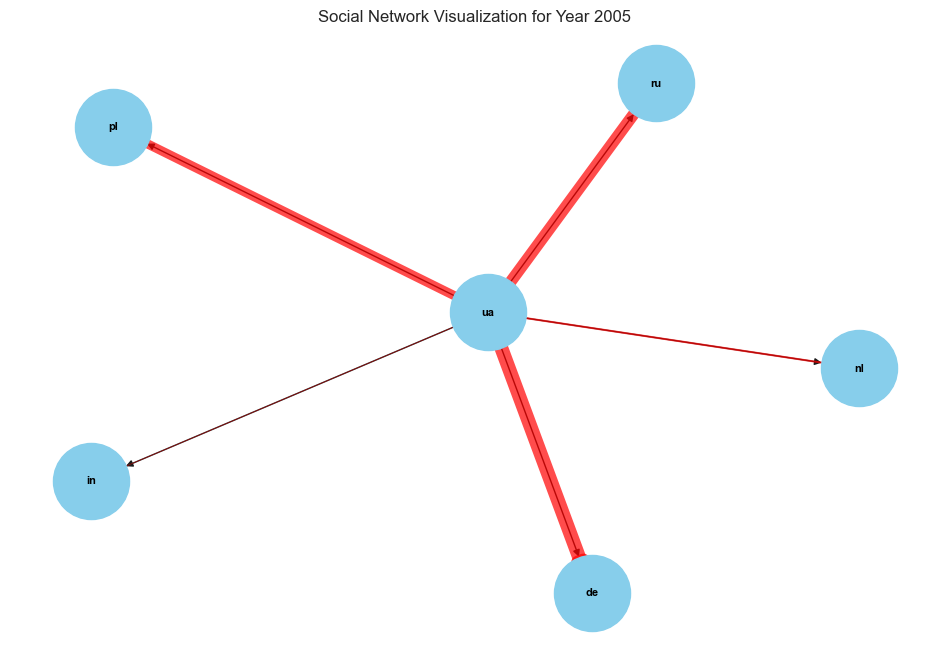

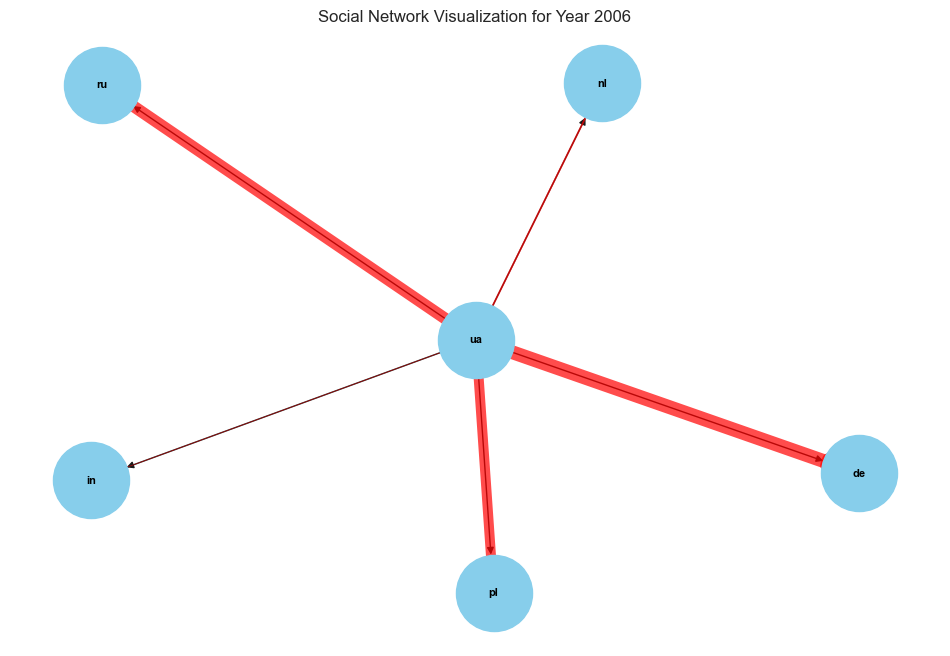

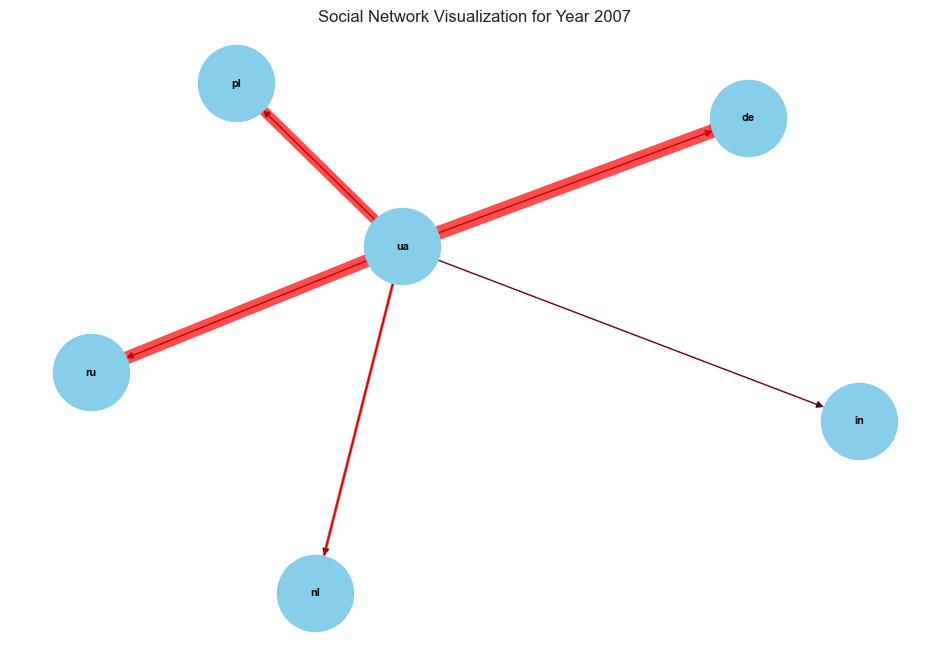

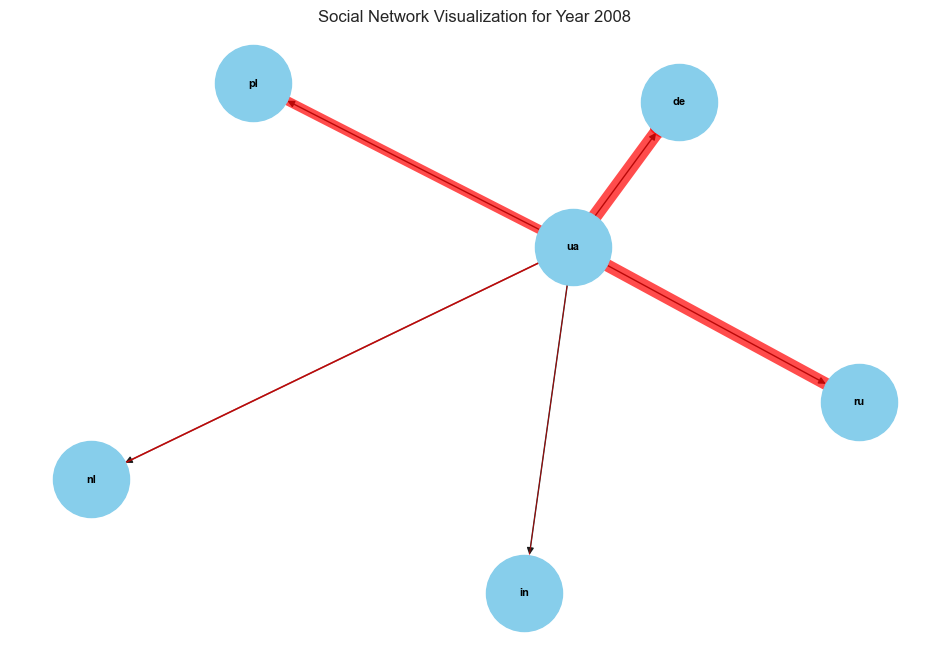

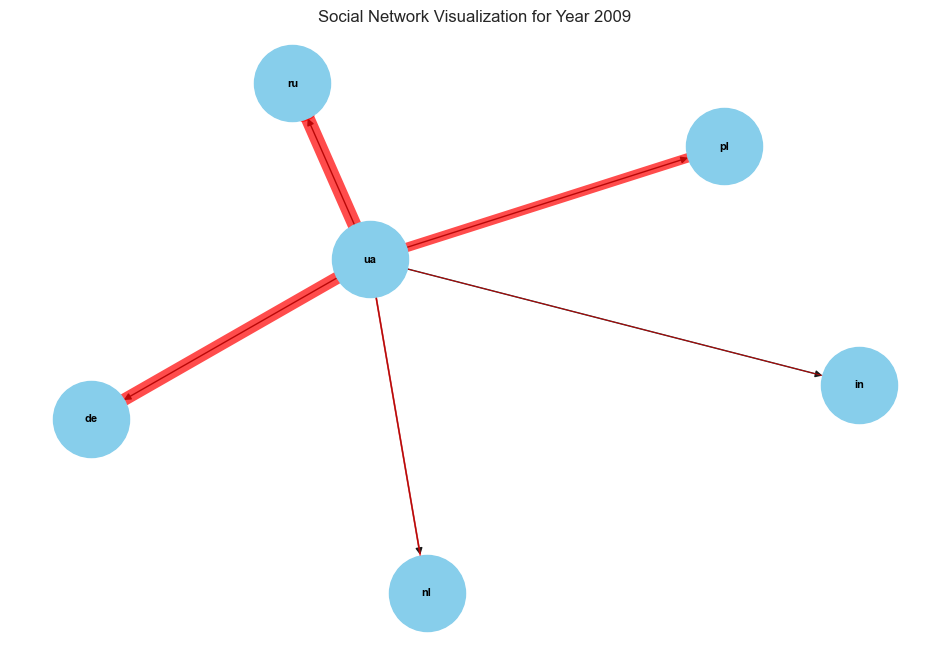

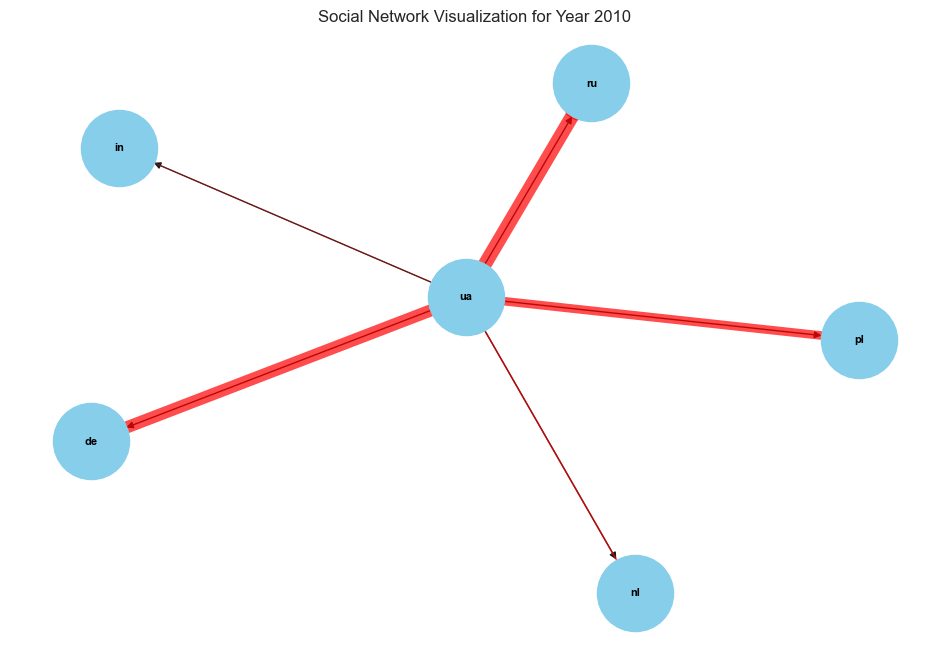

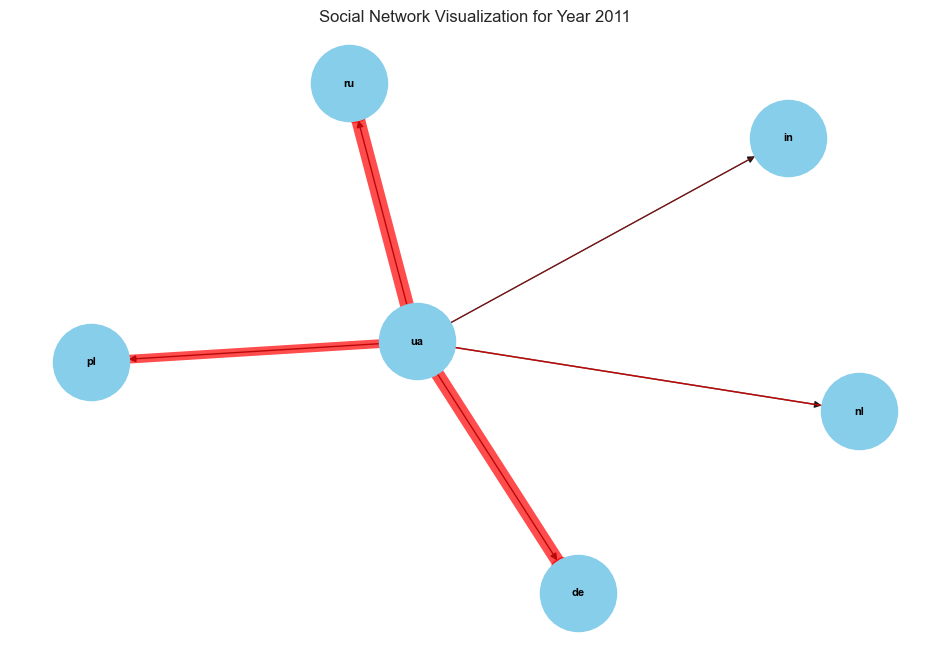

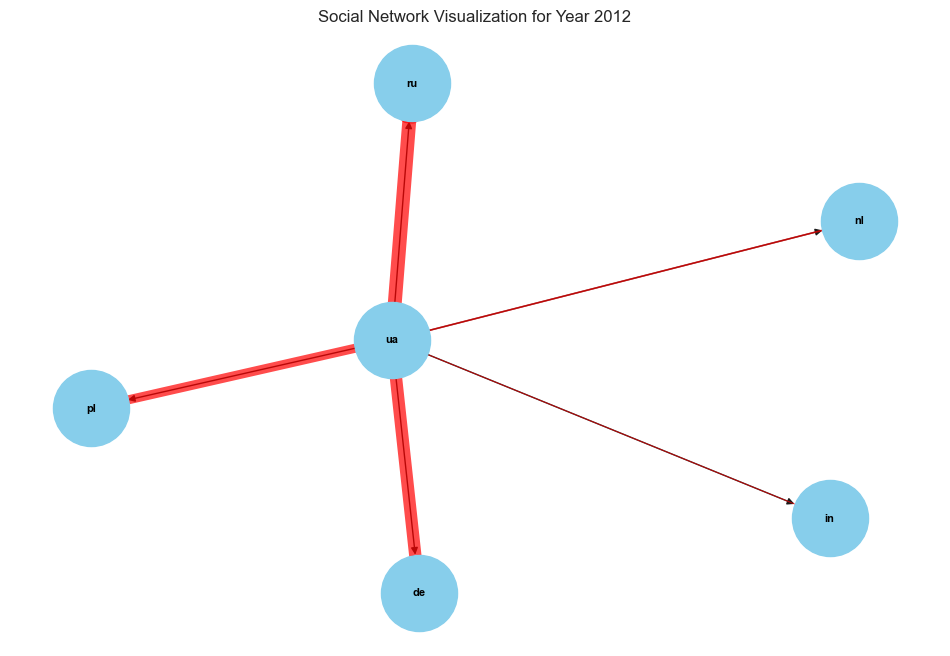

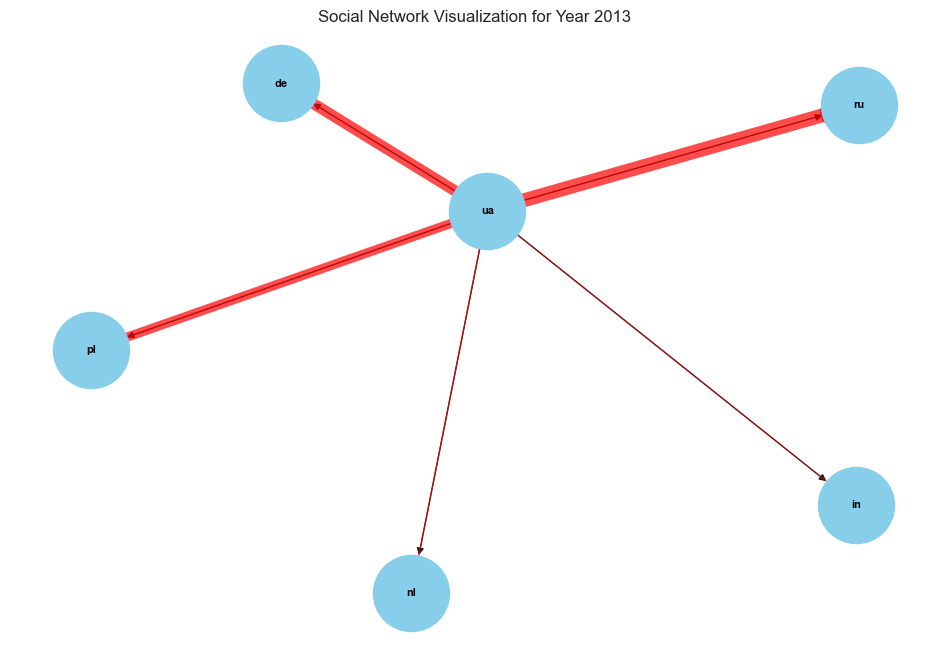

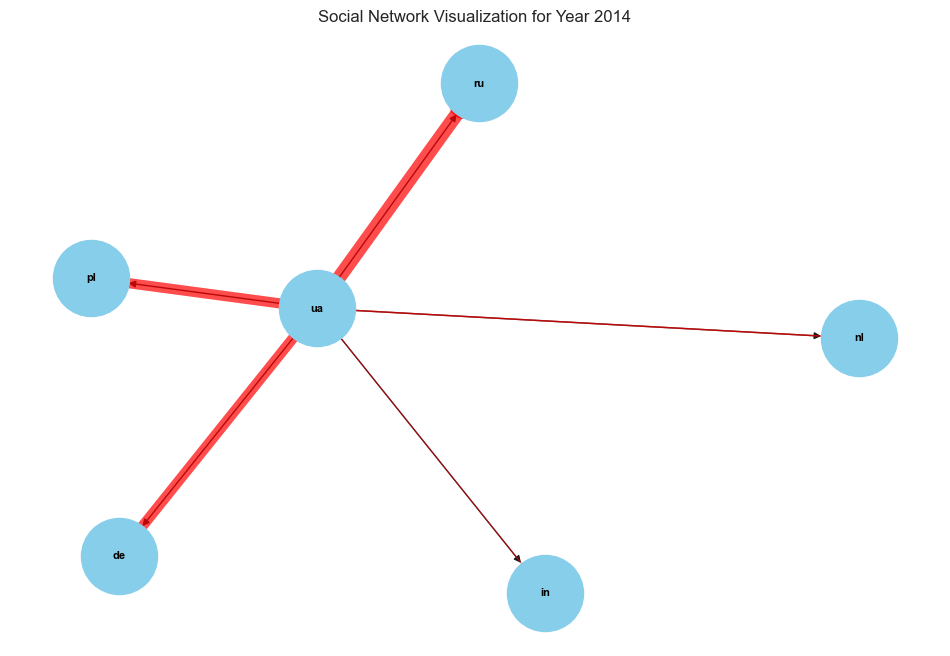

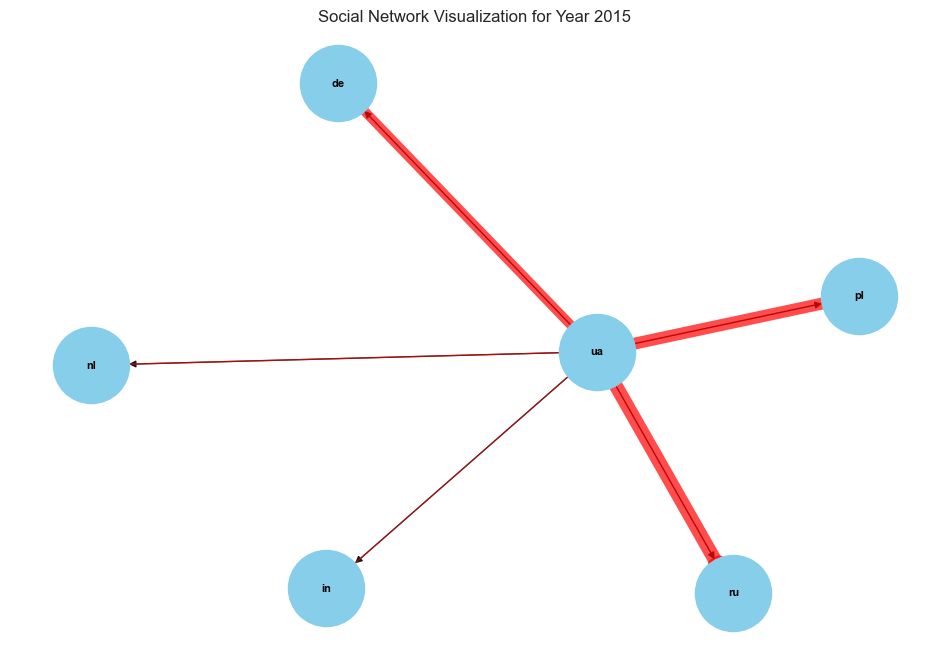

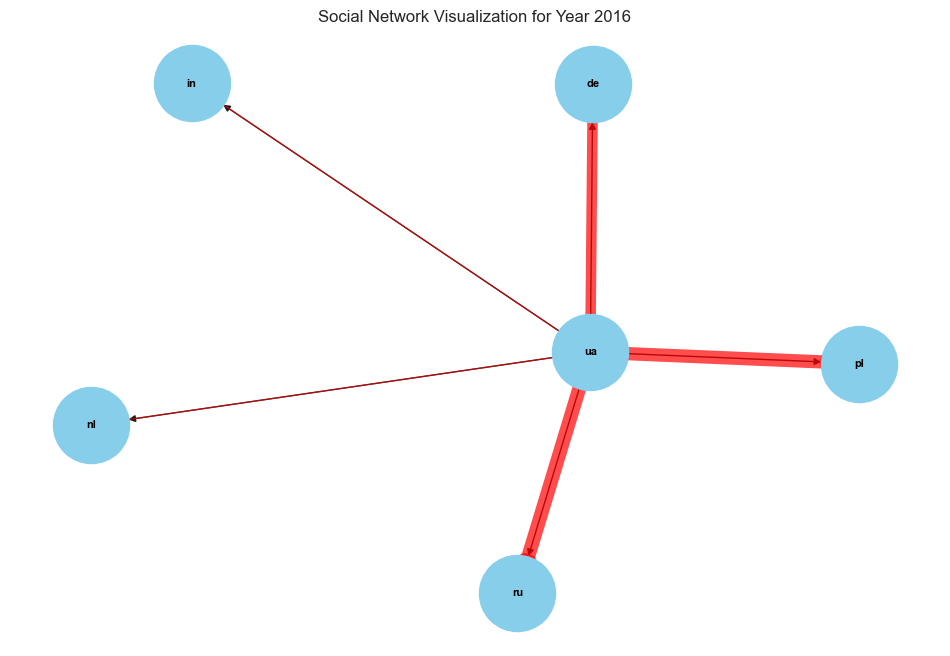

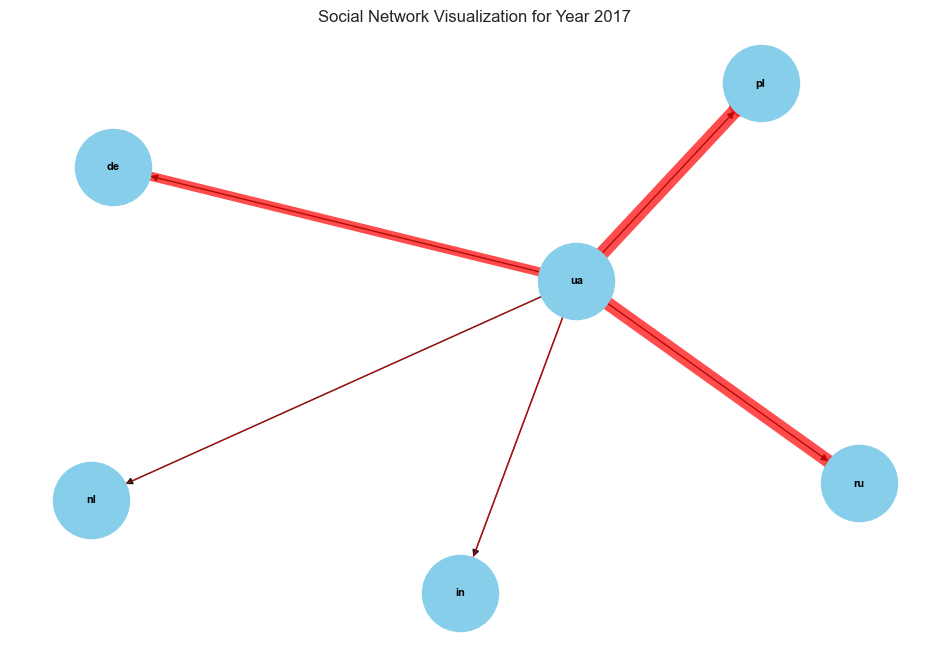

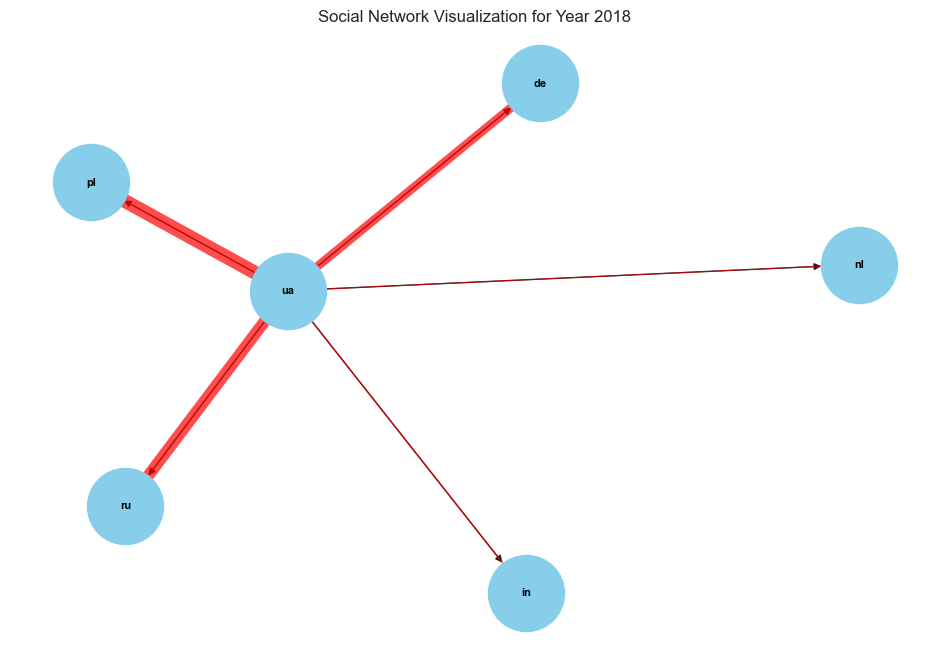

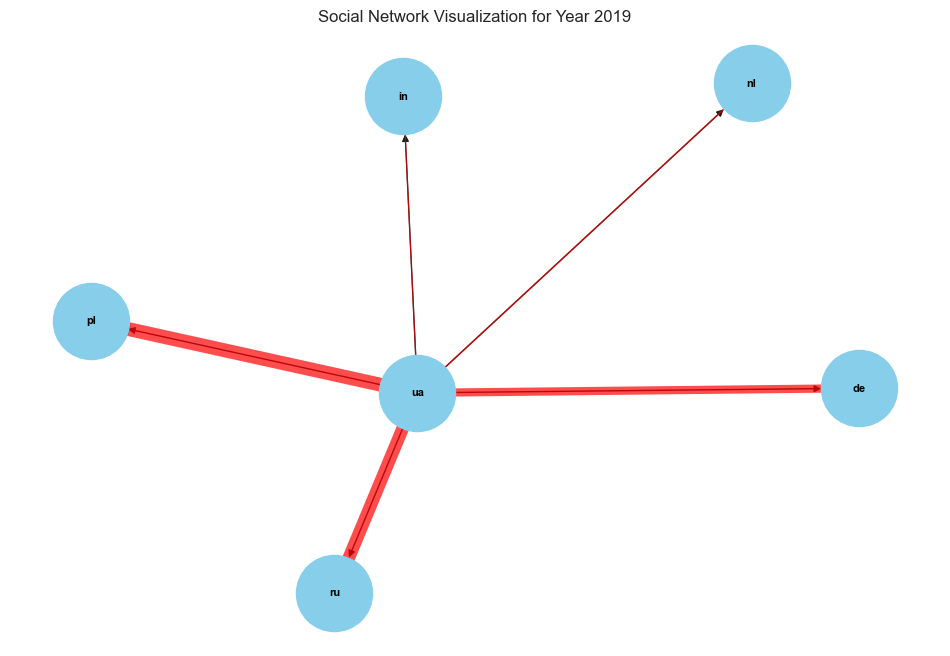

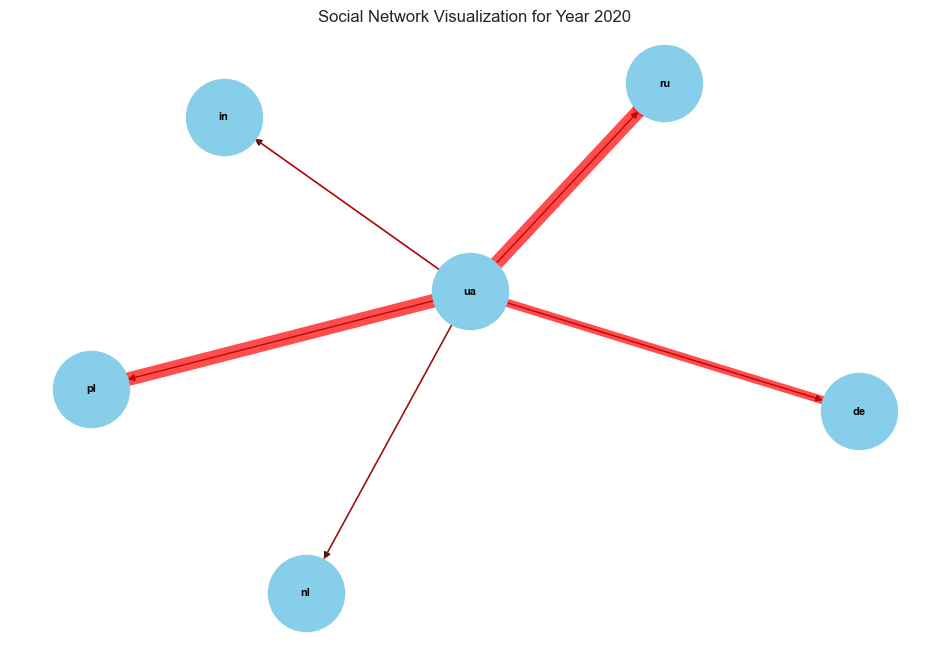

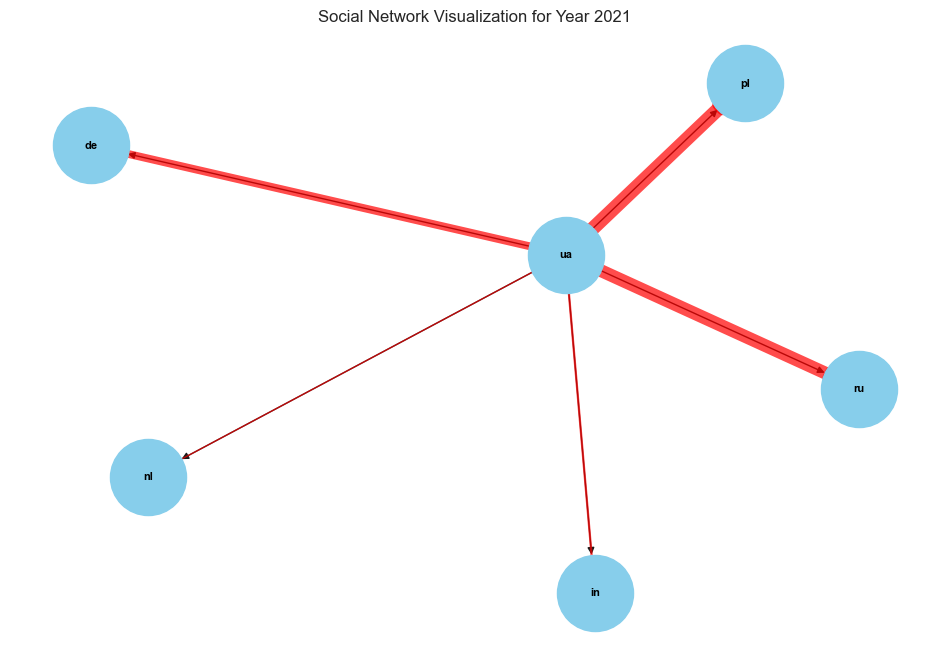

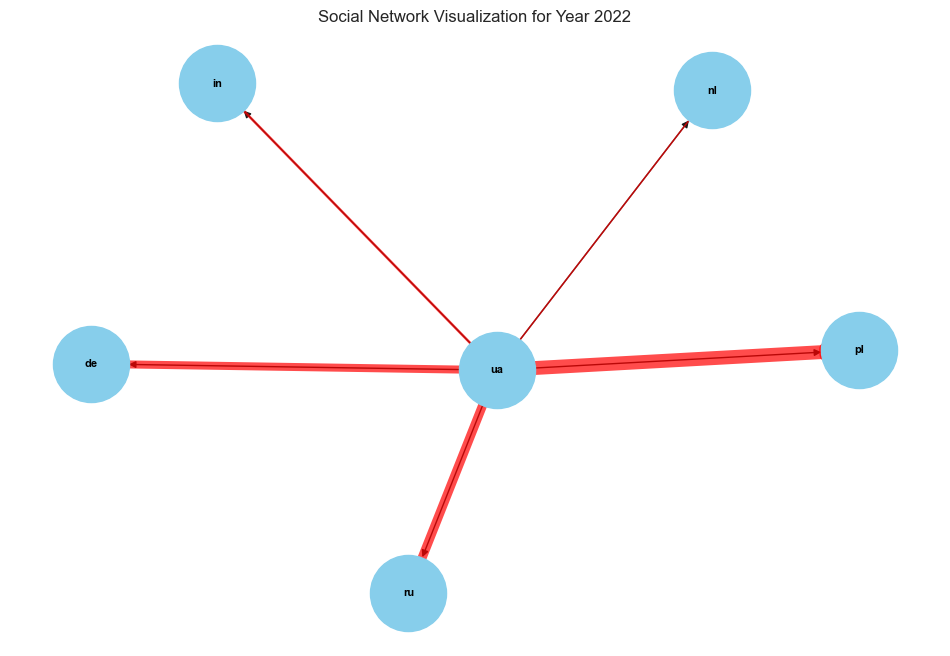

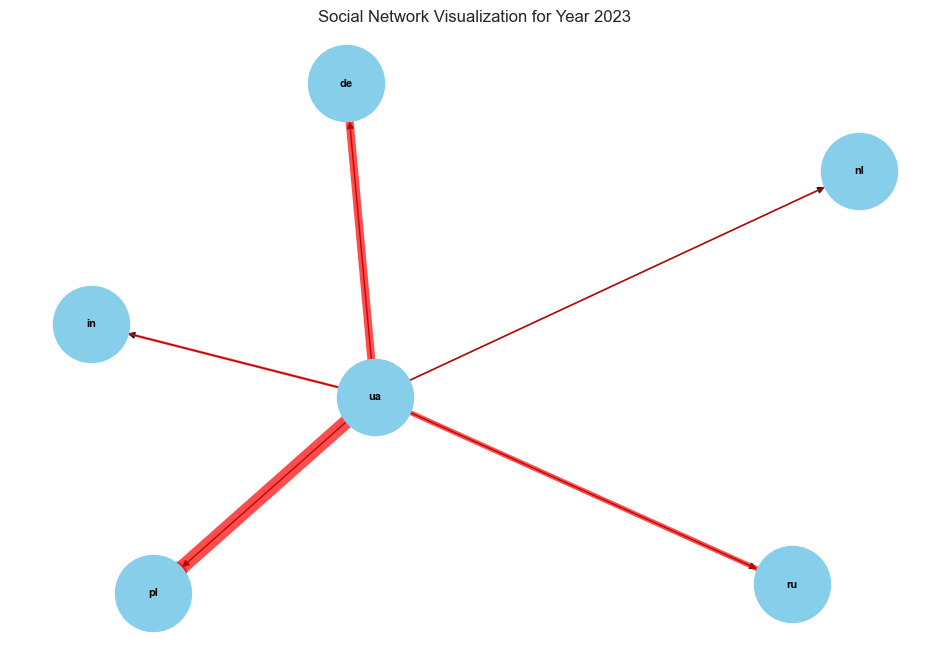

In [60]:
# Create a network visualization for each year
for year in years:
    # Extract edges and weights for the specific year
    year_df = metadata_df[metadata_df['Year'] == year]
    edges = [(row['Country'].split(' to ')[0], row['Country'].split(' to ')[1]) for _, row in year_df.iterrows()]
    weights = {tuple(row['Country'].split(' to ')): row['Count'] for _, row in year_df.iterrows()}

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph based on metadata_df
    for _, row in year_df.iterrows():
        source = row['Country'].split(' to ')[0]
        target = row['Country'].split(' to ')[1]
        weight = row['Count']

        # Remove connections from a node to itself
        if source != target:
            G.add_edge(source, target, weight=weight)

    # Plot the graph
    plt.figure(figsize=(12, 8))
    plt.title(f'Social Network Visualization for Year {year}')

    # Draw the network within the new figure, specifying the ax parameter
    pos = nx.spring_layout(G)

    # Normalize edge weights for thickness
    max_weight = max(weights.values())
    normalized_weights = [weight / max_weight for weight in weights.values()]

    # Draw nodes
    nx.draw(G, pos, with_labels=True, font_size=8, node_size=3000, node_color='skyblue', font_color='black', font_weight='bold', ax=plt.gca())

    # Draw edges with thickness based on normalized weight
    nx.draw_networkx_edges(G, pos, width=[10 * weight for weight in normalized_weights], edge_color='red', alpha=0.7)

    # Show the plot
    plt.show()


Some tests with linear regressions.

In [68]:
# Print the resulting DataFrames
for df_name, df in country_combination_dfs.items():
    print(f"\nDataFrame for {df_name}:")
    print(df)


DataFrame for ua_to_de:
    Year  Weight  Prediction  Deviation
0   2001     315         NaN        NaN
1   2002     335         NaN        NaN
2   2003     391  355.000000   5.970149
3   2004     407  423.000000   8.184143
4   2005     365  445.000000   9.336609
5   2006     430  414.200000  13.479452
6   2007     428  441.933333   2.775194
7   2008     443  453.428571   5.941255
8   2009     410  466.178571   5.232183
9   2010     427  458.305556  11.781843
10  2011     529  459.133333   7.525371
11  2012     540  496.181818  -6.203815
12  2013     564  525.606061  -2.665544
13  2014     604  553.923077  -1.786688
14  2015     603  586.000000  -2.980132
15  2016     695  609.733333   1.116639
16  2017     672  650.675000  -6.377698
17  2018     731  677.198529   0.773591
18  2019     808  711.078431  -2.725249
19  2020     838  754.350877  -6.639743
20  2021     844  795.478947  -5.074111
21  2022     875  830.314286  -1.621530
22  2023     866  864.662338  -1.181447

DataFrame for 

In [69]:
# Function to create predictions and calculate deviation
def predict_and_evaluate(df, train_years, predict_year):
    # Select the training and testing data
    train_data = df[df['Year'].isin(train_years)]
    test_data = df[df['Year'] == predict_year]

    # Prepare the training features and target variable
    X_train = train_data[['Year']]
    y_train = train_data['Weight']

    # Prepare the testing features
    X_test = test_data[['Year']]

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict the values for the testing set
    y_pred = model.predict(X_test)

    # Calculate deviation
    deviation = y_pred[0] - test_data['Weight'].values[0]

    return y_pred[0], deviation

# Create new columns for predictions and deviation
df['Prediction'] = np.nan
df['Deviation'] = np.nan

# Predict each year using the preceding years
for i in range(2, len(df)):
    df.loc[i, 'Prediction'], df.loc[i, 'Deviation'] = predict_and_evaluate(df, df['Year'].iloc[:i], df['Year'].iloc[i])


In [51]:
# Iterate through the DataFrames
for df_name, df in country_combination_dfs.items():
    # Create new columns for predictions and deviation
    df['Prediction'] = np.nan
    df['Deviation'] = np.nan

    # Predict each year using the preceding years
    for i in range(2, len(df)):
        df.loc[i, 'Prediction'], df.loc[i, 'Deviation'] = predict_and_evaluate(df, df['Year'].iloc[:i], df['Year'].iloc[i])

    # Print the updated DataFrame
    print(f"\nDataFrame for {df_name}:")
    print(df)


DataFrame for ua_to_de:
    Year  Weight  Prediction  Deviation
0   2001     314         NaN        NaN
1   2002     334         NaN        NaN
2   2003     391  354.000000 -37.000000
3   2004     407  423.333333  16.333333
4   2005     364  445.500000  81.500000
5   2006     430  413.900000 -16.100000
6   2007     429  441.933333  12.933333
7   2008     443  454.142857  11.142857
8   2009     410  466.785714  56.785714
9   2010     427  458.833333  31.833333
10  2011     530  459.600000 -70.400000
11  2012     541  496.963636 -44.036364
12  2013     562  526.606061 -35.393939
13  2014     604  554.153846 -49.846154
14  2015     602  586.219780 -15.780220
15  2016     695  609.676190 -85.323810
16  2017     671  650.650000 -20.350000
17  2018     729  676.963235 -52.036765
18  2019     805  710.450980 -94.549020
19  2020     838  753.192982 -84.807018
20  2021     845  794.484211 -50.515789
21  2022     875  829.647619 -45.352381
22  2023     863  864.090909   1.090909

DataFrame for 

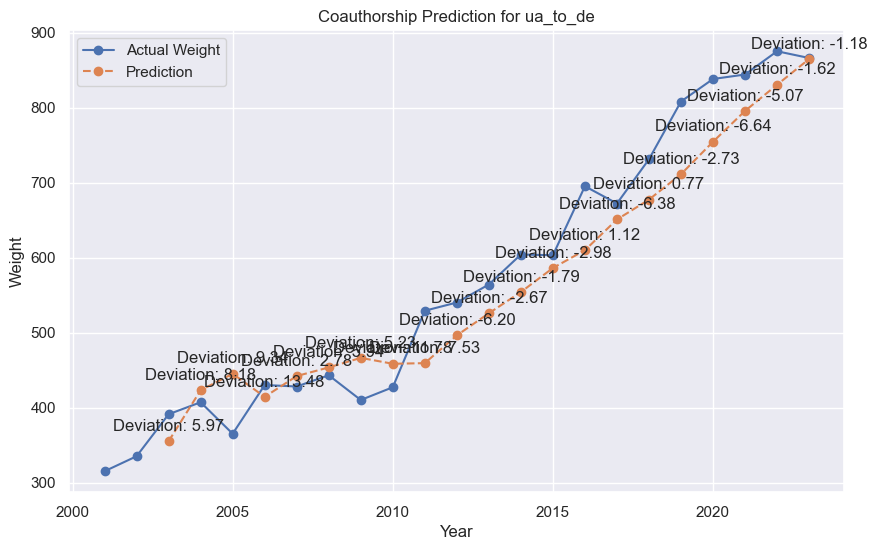

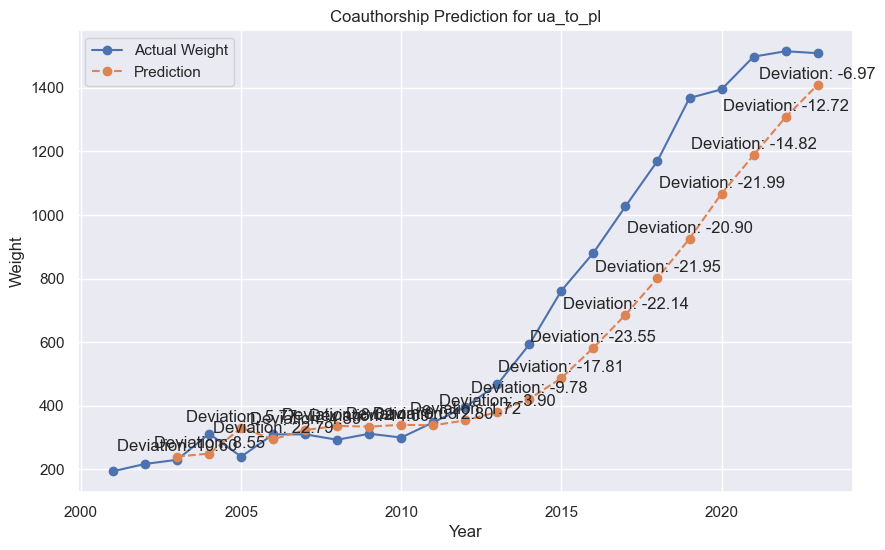

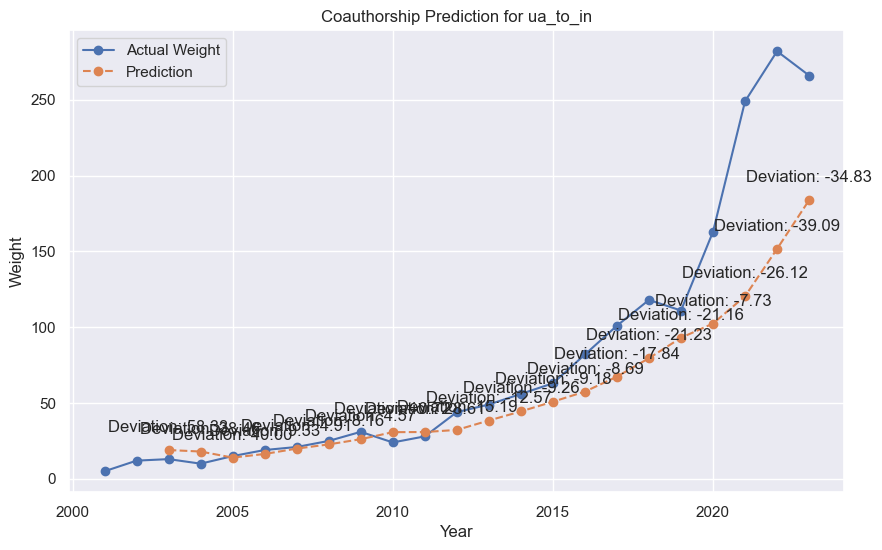

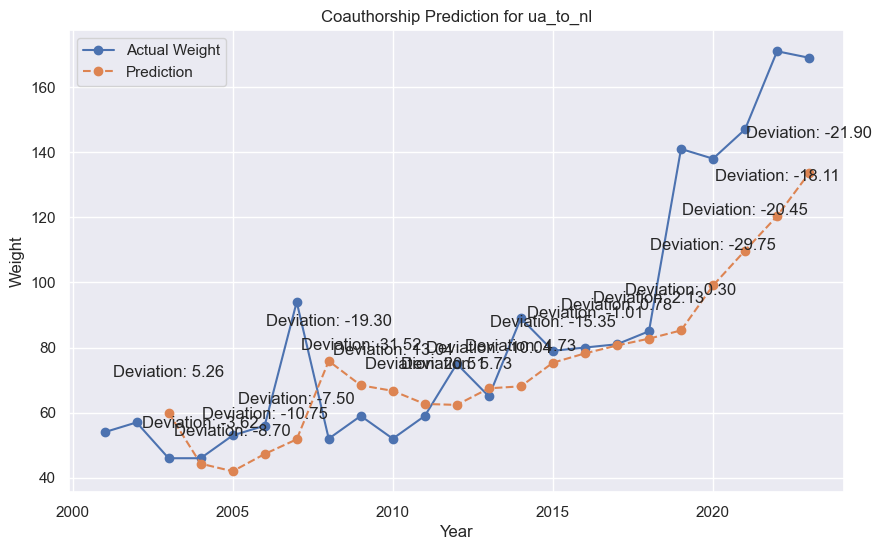

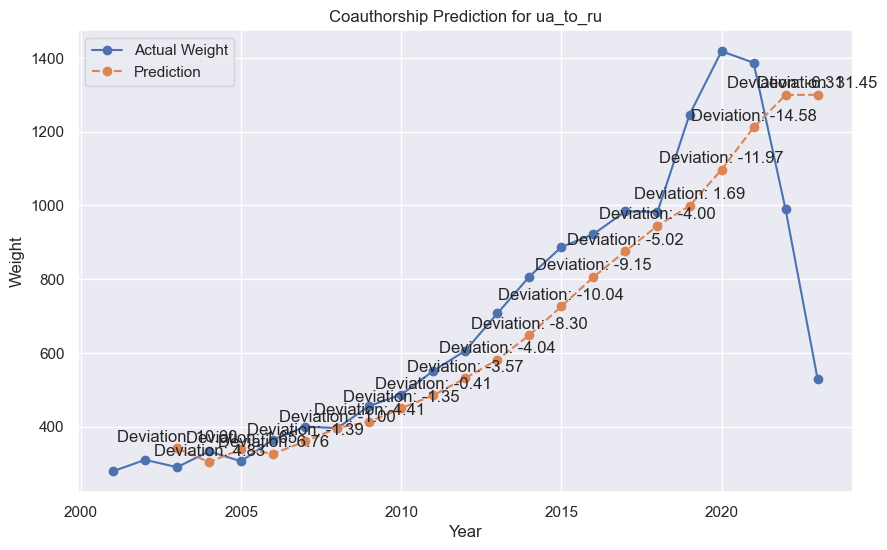

In [77]:
# Iterate through the DataFrames
for df_name, df in country_combination_dfs.items():
    # Plot the actual weights
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Weight'], label='Actual Weight', marker='o')
    
    # Plot the predictions
    plt.plot(df['Year'], df['Prediction'], label='Prediction', linestyle='--', marker='o')
    
    # Add deviation information to the plot
    for i, txt in enumerate(df['Deviation']):
        plt.annotate(f'Deviation: {txt:.2f}', (df['Year'].iloc[i], df['Prediction'].iloc[i] + 10), ha='center', va='bottom')

    # Set plot properties
    plt.title(f"Coauthorship Prediction for {df_name}")
    plt.xlabel('Year')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()



DataFrame for ua_to_de:
    Year  Weight  Prediction  Deviation           P          D
0   2001     315         NaN        NaN         NaN        NaN
1   2002     335         NaN        NaN         NaN        NaN
2   2003     391  355.000000   5.970149  355.000000   5.970149
3   2004     407  423.000000   8.184143  423.000000   8.184143
4   2005     365  445.000000   9.336609  445.000000   9.336609
5   2006     430  414.200000  13.479452  414.200000  13.479452
6   2007     428  441.933333   2.775194  441.933333   2.775194
7   2008     443  453.428571   5.941255  453.428571   5.941255
8   2009     410  466.178571   5.232183  466.178571   5.232183
9   2010     427  458.305556  11.781843  458.305556  11.781843
10  2011     529  459.133333   7.525371  459.133333   7.525371
11  2012     540  496.181818  -6.203815  496.181818  -6.203815
12  2013     564  525.606061  -2.665544  525.606061  -2.665544
13  2014     604  553.923077  -1.786688  553.923077  -1.786688
14  2015     603  586.000000  

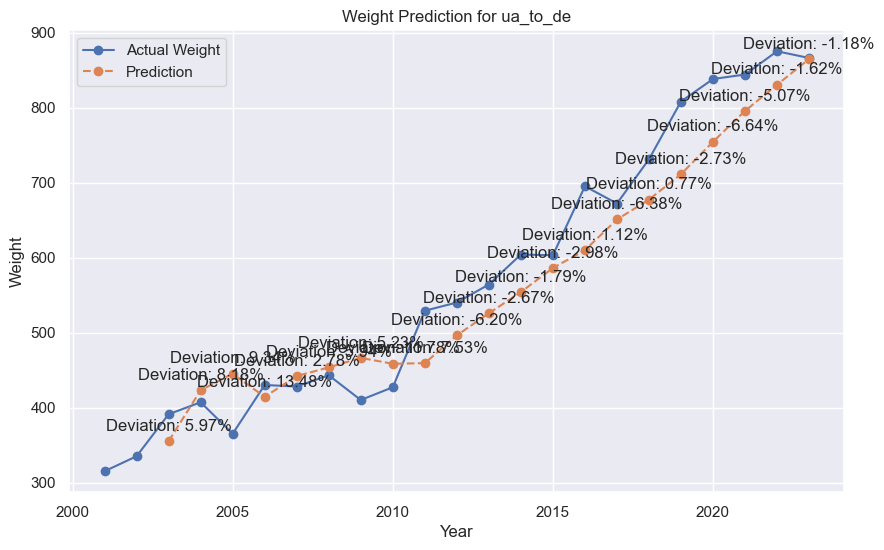


DataFrame for ua_to_pl:
    Year  Weight   Prediction  Deviation            P          D
0   2001     194          NaN        NaN          NaN        NaN
1   2002     217          NaN        NaN          NaN        NaN
2   2003     230   240.000000  10.599078   240.000000  10.599078
3   2004     312   249.666667   8.550725   249.666667   8.550725
4   2005     240   330.000000   5.769231   330.000000   5.769231
5   2006     310   294.700000  22.791667   294.700000  22.791667
6   2007     310   323.600000   4.387097   323.600000   4.387097
7   2008     293   336.714286   8.617512   336.714286   8.617512
8   2009     312   334.285714  14.090687   334.285714  14.090687
9   2010     300   340.166667   9.027778   340.166667   9.027778
10  2011     348   338.400000  12.800000   338.400000  12.800000
11  2012     396   354.000000   1.724138   354.000000   1.724138
12  2013     467   380.545455  -3.902663   380.545455  -3.902663
13  2014     593   421.307692  -9.784220   421.307692  -9.784220


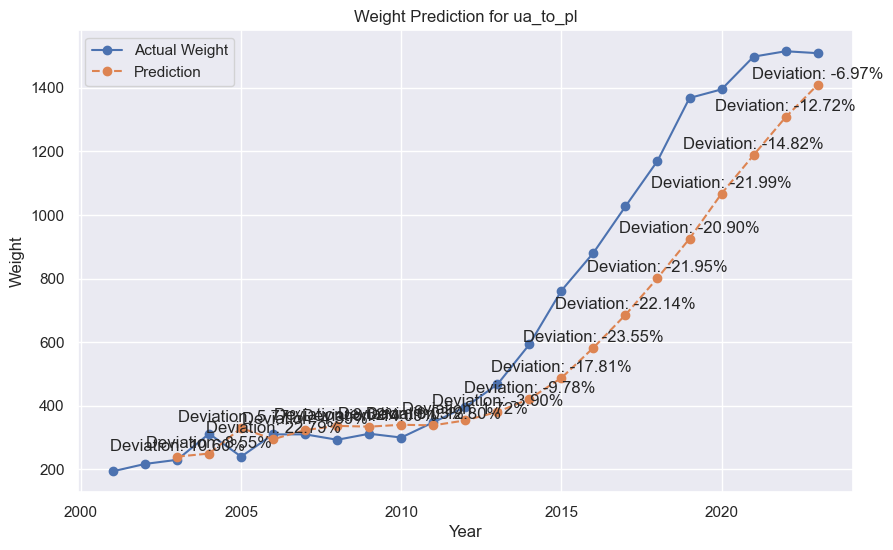


DataFrame for ua_to_in:
    Year  Weight  Prediction  Deviation           P          D
0   2001       5         NaN        NaN         NaN        NaN
1   2002      12         NaN        NaN         NaN        NaN
2   2003      13   19.000000  58.333333   19.000000  58.333333
3   2004      10   18.000000  38.461538   18.000000  38.461538
4   2005      15   14.000000  40.000000   14.000000  40.000000
5   2006      19   16.400000   9.333333   16.400000   9.333333
6   2007      21   19.933333   4.912281   19.933333   4.912281
7   2008      25   22.714286   8.163265   22.714286   8.163265
8   2009      31   26.142857   4.571429   26.142857   4.571429
9   2010      24   30.777778  -0.716846   30.777778  -0.716846
10  2011      28   30.866667  28.611111   30.866667  28.611111
11  2012      44   32.254545  15.194805   32.254545  15.194805
12  2013      49   38.469697 -12.568871   38.469697 -12.568871
13  2014      56   44.461538  -9.262166   44.461538  -9.262166
14  2015      63   50.857143  

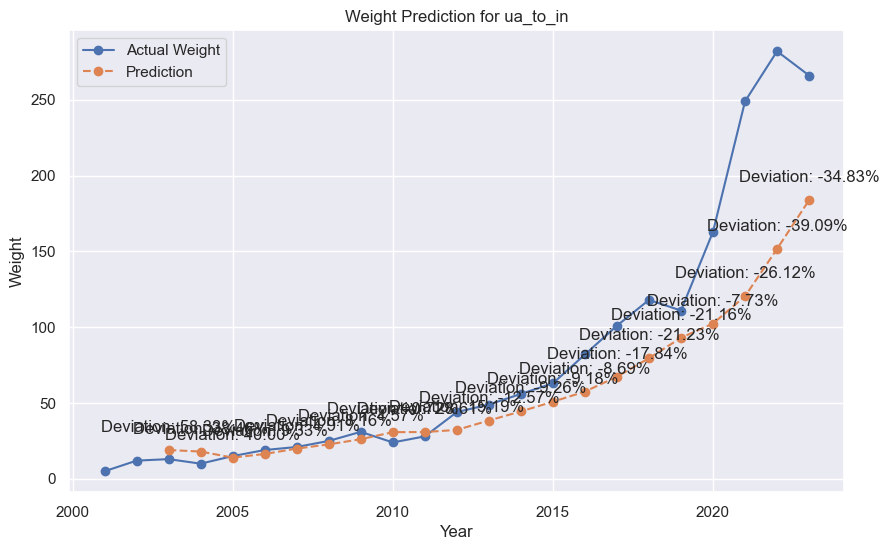


DataFrame for ua_to_nl:
    Year  Weight  Prediction  Deviation           P          D
0   2001      54         NaN        NaN         NaN        NaN
1   2002      57         NaN        NaN         NaN        NaN
2   2003      46   60.000000   5.263158   60.000000   5.263158
3   2004      46   44.333333  -3.623188   44.333333  -3.623188
4   2005      53   42.000000  -8.695652   42.000000  -8.695652
5   2006      56   47.300000 -10.754717   47.300000 -10.754717
6   2007      94   51.800000  -7.500000   51.800000  -7.500000
7   2008      52   75.857143 -19.300912   75.857143 -19.300912
8   2009      59   68.392857  31.524725   68.392857  31.524725
9   2010      52   66.694444  13.041431   66.694444  13.041431
10  2011      59   62.666667  20.512821   62.666667  20.512821
11  2012      75   62.381818   5.731895   62.381818   5.731895
12  2013      65   67.469697 -10.040404   67.469697 -10.040404
13  2014      89   68.076923   4.733728   68.076923   4.733728
14  2015      79   75.340659 -

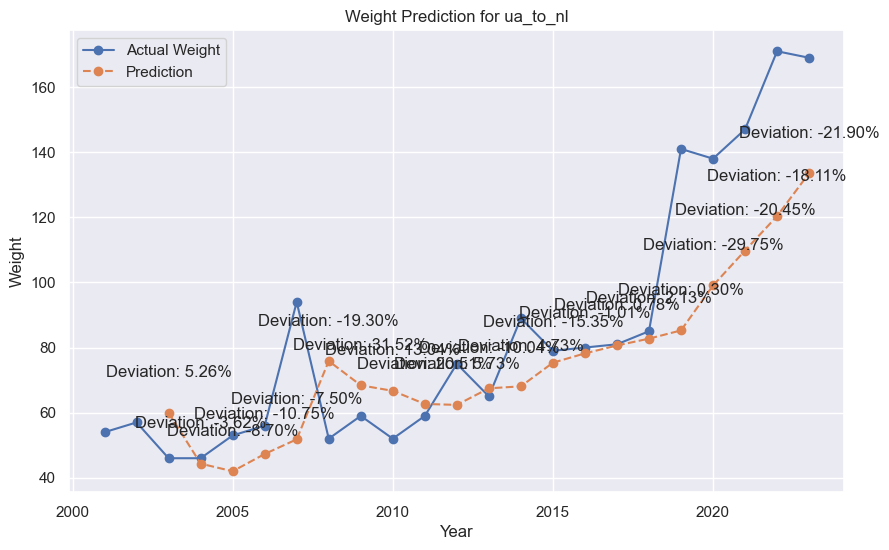


DataFrame for ua_to_ru:
    Year  Weight   Prediction  Deviation            P          D
0   2001     279          NaN        NaN          NaN        NaN
1   2002     310          NaN        NaN          NaN        NaN
2   2003     290   341.000000  10.000000   341.000000  10.000000
3   2004     333   304.000000   4.827586   304.000000   4.827586
4   2005     306   338.500000   1.651652   338.500000   1.651652
5   2006     365   326.700000   6.764706   326.700000   6.764706
6   2007     400   359.933333  -1.388128   359.933333  -1.388128
7   2008     396   396.000000  -1.000000   396.000000  -1.000000
8   2009     456   413.464286   4.410173   413.464286   4.410173
9   2010     487   449.833333  -1.352339   449.833333  -1.352339
10  2011     551   485.000000  -0.410678   485.000000  -0.410678
11  2012     606   531.327273  -3.570368   531.327273  -3.570368
12  2013     707   581.545455  -4.035404   581.545455  -4.035404
13  2014     807   648.346154  -8.296159   648.346154  -8.296159


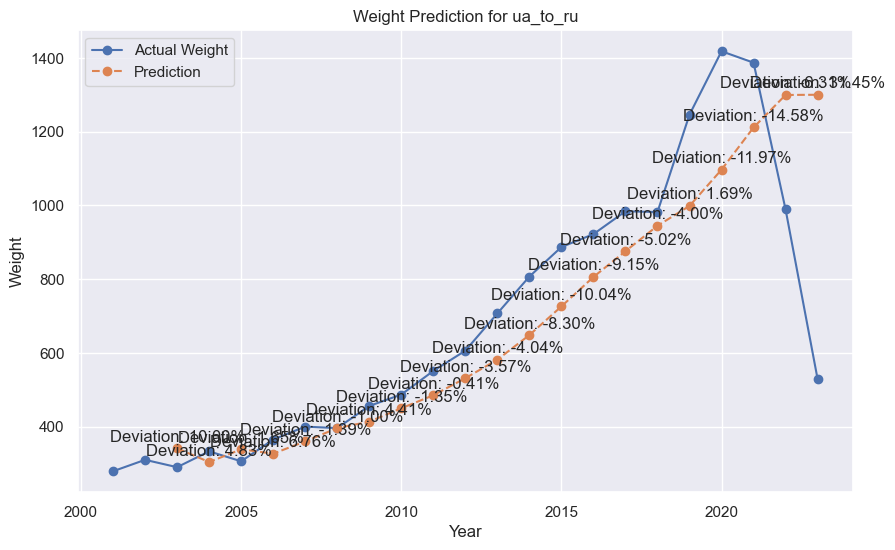

In [79]:
# Iterate through the DataFrames
for df_name, df in country_combination_dfs.items():
    # Create new columns for predictions and deviation
    df['Prediction'] = np.nan
    df['Deviation'] = np.nan

    # Predict each year using the preceding years
    for i in range(2, len(df)):
        prediction, deviation = predict_and_evaluate(df, df['Year'].iloc[:i], df['Year'].iloc[i])
        df.loc[i, 'Prediction'] = prediction
        df.loc[i, 'Deviation'] = (prediction - df['Weight'].iloc[i-1]) / df['Weight'].iloc[i-1] * 100

    # Print the updated DataFrame
    print(f"\nDataFrame for {df_name}:")
    print(df)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Weight'], label='Actual Weight', marker='o')
    plt.plot(df['Year'], df['Prediction'], label='Prediction', linestyle='--', marker='o')

    # Add deviation information to the plot
    for i, txt in enumerate(df['Deviation']):
        plt.annotate(f'Deviation: {txt:.2f}%', (df['Year'].iloc[i], df['Prediction'].iloc[i] + 10), ha='center', va='bottom')

    # Set plot properties
    plt.title(f"Weight Prediction for {df_name}")
    plt.xlabel('Year')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()